In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, MaxPooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
def extract_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=22050)  # Chargement de l'audio avec SR fixe
    
    # Tronquer ou zero-padding à 3 secondes
    max_length = sr * 3
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), "constant")

    # Extraction des caractéristiques
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T, axis=0)

    # Combiner toutes les caractéristiques
    features = np.hstack([mfcc, chroma, contrast, tonnetz])
    return features

# Fonction d'augmentation des données
def augment_audio(audio, sr):
    # Ajout de bruit
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise

    # Pitch shifting
    audio_pitch = librosa.effects.pitch_shift(audio, sr, n_steps=2)

    # Time stretching
    audio_stretch = librosa.effects.time_stretch(audio, rate=0.9)

    return [audio, audio_noise, audio_pitch, audio_stretch]


In [3]:
import os
import librosa
import numpy as np

# Chemin vers le dataset
DATASET_PATH = "/kaggle/input/ravdess-emotional-speech-audio"

# Variables pour stocker les données et les labels
X = []
y = []

# Mappage des émotions (par exemple, vous pouvez adapter selon le dataset)
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_features(audio, sr=22050):
    # Si 'audio' est un chemin de fichier, charger l'audio
    if isinstance(audio, str):  # Si audio est une chaîne (chemin de fichier)
        audio, sr = librosa.load(audio, sr=sr)
    
    # Assurez-vous que l'audio est de type float32
    audio = np.array(audio, dtype=np.float32)

    # Tronquer ou zero-padding à 3 secondes
    max_length = sr * 3
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), "constant")

    # Extraction des caractéristiques
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T, axis=0)

    # Combiner toutes les caractéristiques
    features = np.hstack([mfcc, chroma, contrast, tonnetz])
    return features


# Fonction d'augmentation des données
def augment_audio(audio, sr):
    # Ajout de bruit
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise

    # Pitch shifting
    audio_pitch = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)

    # Time stretching
    audio_stretch = librosa.effects.time_stretch(y=audio, rate=0.9)

    return [audio, audio_noise, audio_pitch, audio_stretch]


# Parcours des acteurs et des fichiers audio
for actor_id in range(1, 25):  # De Actor_01 à Actor_24
    actor_folder = os.path.join(DATASET_PATH, f"Actor_{actor_id:02d}")  # Format Actor_01, Actor_02, ...
    
    for file in os.listdir(actor_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_folder, file)
            
            # Extraction des caractéristiques pour l'audio original
            features = extract_features(file_path)
            
            # Extraction de l'émotion à partir du nom du fichier (par exemple, '01-01-01-01.wav' -> '01')
            emotion = emotion_map[file.split('-')[2]]
            
            X.append(features)
            y.append(emotion)
            
            # Augmenter les données (bruit, pitch shifting, time stretching)
            audio, sr = librosa.load(file_path, sr=22050)
            augmented_audio = augment_audio(audio, sr)
            # Extraction des caractéristiques pour chaque audio augmenté
            for aug_audio in augmented_audio:
                aug_features = extract_features(aug_audio, sr)  # Passer directement l'audio et sr
                X.append(aug_features)
                y.append(emotion)


# Convertir les listes en tableaux NumPy
X = np.array(X)
y = np.array(y)

# Vous pouvez maintenant continuer avec l'encodage des étiquettes et la préparation des données


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convertir les labels en entiers
y_categorical = to_categorical(y_encoded)  # One-hot encoding

In [6]:
# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

In [7]:
# Reshape pour CNN
X_train = X_train[..., np.newaxis]  # Ajout d'une dimension
X_test = X_test[..., np.newaxis]

In [9]:
# Construction du modèle CNN + LSTM
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),  # ✅ Définit la taille de l'entrée ici
    Conv1D(64, kernel_size=3, activation='relu'), 
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_map), activation='softmax')  # Nombre de classes
])

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Callback pour réduire le learning rate si la validation stagne
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [10]:
# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr]
)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.1918 - loss: 2.0242 - val_accuracy: 0.2806 - val_loss: 1.8611 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3071 - loss: 1.8087 - val_accuracy: 0.3743 - val_loss: 1.6859 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3586 - loss: 1.7242 - val_accuracy: 0.4007 - val_loss: 1.5947 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3725 - loss: 1.6472 - val_accuracy: 0.4194 - val_loss: 1.5268 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4082 - loss: 1.5890 - val_accuracy: 0.4208 - val_loss: 1.5201 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4286 - loss: 1.5437 - val_accuracy: 0.4604 - val_loss: 1.4149 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4684 - loss: 1

In [11]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Précision du modèle : {accuracy * 100:.2f}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.5736
Précision du modèle : 83.61%


In [12]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Rapport de classification
print("Rapport de Classification :\n", classification_report(y_test_classes, y_pred_classes, target_names=emotion_map.values()))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Rapport de Classification :
               precision    recall  f1-score   support

     neutral       0.91      0.89      0.90       192
        calm       0.81      0.85      0.83       192
       happy       0.78      0.84      0.81       192
         sad       0.84      0.84      0.84       192
       angry       0.84      0.78      0.81       192
     fearful       0.82      0.78      0.80        96
     disgust       0.77      0.81      0.79       192
   surprised       0.92      0.87      0.90       192

    accuracy                           0.84      1440
   macro avg       0.84      0.83      0.83      1440
weighted avg       0.84      0.84      0.84      1440



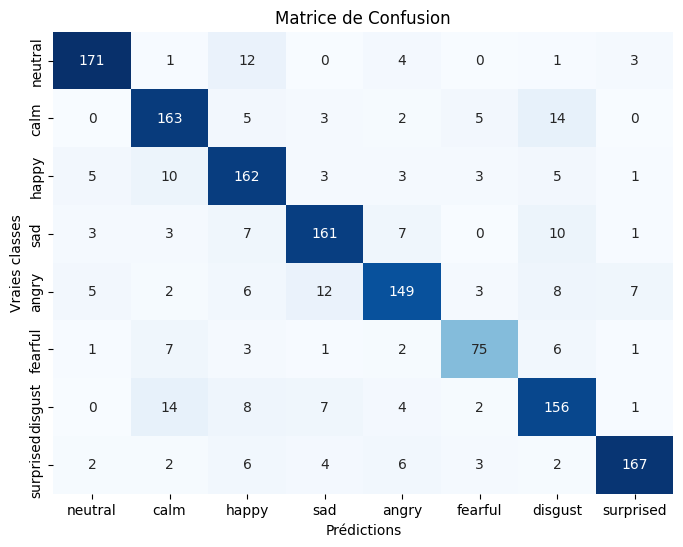

In [13]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_map.values(), yticklabels=emotion_map.values(), cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')
plt.title("Matrice de Confusion")
plt.show()

In [17]:
# Sauvegarde du modèle
model.save("emotion_recognition_model.h5")